In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable

import data
from recurrent_attention import RecurrentAttention

## Overhead stuff

Helper functions for batching, resetting hidden states, etc.

In [2]:
# Training hyperparameters
eval_batch_size = 10
batch_size = 74
seq_len = 18
dropout = 0.1
clip = 1
lr = 0.1
warmup_steps = 5
decay_factor = 0.5
smooth_labels = True

epochs = 150
log_interval = 100  # Print log every `log_interval` batches

In [3]:
# Model hyperparameters
embed_size = 256
encode_size = 128
h_size = 64
attn_out_size = 128
decode_size = 256
n_layers = 2
attn_rnn_layers = 1
bidirectional_attn = False

In [4]:
# Starting from sequential data, `batchify` arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.
def batchify(data, batch_size):
    # Work out how cleanly we can divide the dataset into batches
    nbatches = data.size(0) // batch_size
    # Trim off any extra elements that wouldn't cleanly fit
    data = data.narrow(0, 0, nbatches * batch_size)
    # Evenly divide the data across the batches
    data = data.view(batch_size, -1).t().contiguous()
    return data

# Wraps hidden states into new Variables to detach them from their history
def repackage_hidden(h):
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)
    
# `get_batch` subdivides the source data into chunks of the specified length.
# E.g., using the example for the `batchify` function above and a length of 2,
# we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the `batchify` function. The chunks are along dimension 0, corresponding
# to the `seq_len` dimension in the LSTM.
def get_batch(source, i, seq_len, evaluate = False):
    seq_len = min(seq_len, len(source) - 1 - i)
    data = Variable(source[i : i+seq_len], volatile = evaluate)
    target = Variable(source[i+1 : i+1+seq_len].view(-1), volatile = evaluate)
    return data, target

Label smoothing class for regularization.

In [5]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx = None, smoothing = 0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        if self.padding_idx is not None:
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad = False))

Learning rate scheduler that sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.

In [6]:
def get_lr_scheduler(h_size, warmup, optimizer):
    lrate = lambda e: h_size**(-0.5) * min((e+1)**(-decay_factor), (e+1) * warmup**(-(decay_factor+1)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lrate)

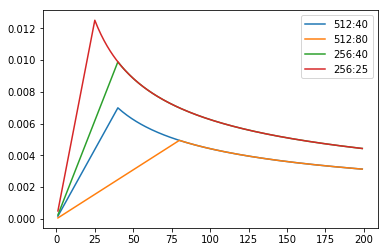

In [7]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(2*lr, embed_size, warmup_steps), 
    lrate(lr, embed_size*2, warmup_steps),
    lrate(lr, embed_size, warmup_steps*3),
    lrate(lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, epochs+1), [[opt(i) for opt in opts] for i in range(1, epochs+1)])
plt.legend(["%.1f:%d:%d", "%.1f:%d:%d", "%.1f:%d:%d", "%.1f:%d:%d" % (
    2*lr_factor*lr, embed_size, warmup_steps,
    lr_factor*lr, embed_size*2, warmup_steps,
    lr_factor*lr, embed_size, warmup_steps*3,
    lr_factor*lr, embed_size, warmup_steps,
)])

## Initialize data

In [8]:
corpus = data.Corpus('./data/ptb')
ntokens = len(corpus.dictionary)

## Model class

In [9]:
class RNNModel(nn.Module):
    def __init__(self, src_vocab, tgt_vocab,
                 embed_size, encode_size, h_size,
                 attn_out_size, decode_size, n_layers,
                 attn_rnn_layers, bidirectional_attn,
                 tie_wts = True, dropout = 0.1):
        super(RNNModel, self).__init__()
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.embed_size = embed_size
        self.encode_size = encode_size
        self.h_size = h_size
        self.attn_out_size = attn_out_size
        self.decode_size = decode_size
        self.n_layers = n_layers
        self.attn_rnn_layers = attn_rnn_layers
        self.bidirectional_attn = bidirectional_attn
        self.tie_wts = tie_wts
        self.dropout = dropout
        
        self.drop = nn.Dropout(dropout)
        
        self.embedding = nn.Embedding(src_vocab, embed_size)
        self.encoder = nn.LSTM(
            input_size = embed_size, hidden_size = encode_size,
            num_layers = n_layers, dropout = dropout
        )
        self.attn = RecurrentAttention(
            in_size = encode_size, h_size = h_size, out_size = attn_out_size,
            dropout = dropout, num_rnn_layers = attn_rnn_layers,
            attn_act_fn = 'Tanh', bidirectional = bidirectional_attn
        )
        self.decoder = nn.LSTM(
            input_size = attn_out_size, hidden_size = decode_size,
            num_layers = n_layers, dropout = dropout
        )
        self.projection = nn.Linear(decode_size, tgt_vocab)
        if tie_wts and src_vocab == tgt_vocab and embed_size == decode_size:
            self.embedding.weight = self.projection.weight
        
    def init(self):
        for subnet in [self.encoder, self.decoder]:
            for p in subnet.parameters():
                if p.dim() > 1:
                    nn.init.xavier_normal(p)
                else:
                    p.data.fill_(0)
        for p in self.linear.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)
            else:
                p.data.fill_(0)
        self.attn.init()
        
    def init_states(self, batch_size):
        encoder_states = (
            Variable(torch.zeros(self.n_layers, batch_size, self.encode_size)),
            Variable(torch.zeros(self.n_layers, batch_size, self.encode_size))
        )
        attn_states = self.attn.init_rnn_states(batch_size)
        decoder_states = (
            Variable(torch.zeros(self.n_layers, batch_size, self.decode_size)),
            Variable(torch.zeros(self.n_layers, batch_size, self.decode_size))
        )
        return encoder_states, attn_states, decoder_states
    
    def forward(self, inputs, states):
        enc_states, attn_states, dec_states = states
        relu = nn.ReLU()
        log_softmax = nn.LogSoftmax(dim = -1)
        
        embeddings = self.embedding(inputs) * np.sqrt(self.embed_size)
        enc_out, new_enc_states = self.encoder(self.drop(embeddings))
        attn_out, new_attn_states = self.attn(enc_out, attn_states)
        dec_out, new_dec_states = self.decoder(relu(attn_out))
        output = self.projection(dec_out)
        if smooth_labels:
            output = log_softmax(output)
        return output, (new_enc_states, new_attn_states, new_dec_states)

## Initialize model, criterion, optimizer, and learning rate scheduler

In [10]:
model = RNNModel(
    ntokens, ntokens, embed_size, encode_size, h_size,
    attn_out_size, decode_size, n_layers, attn_rnn_layers,
    bidirectional_attn, dropout = dropout
)
if smooth_labels:
    criterion = LabelSmoothing(ntokens, smoothing = 0.1)
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9
)
lr_scheduler = get_lr_scheduler(embed_size, warmup_steps, optimizer)

In [11]:
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 6422609


## Train
Ready the data

In [12]:
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

Define training and validation loops

In [13]:
def train():
    # Use random length sequences
    seq_lens = []
    tot_len = 0
    jitter = 0.15 * seq_len
    while tot_len < train_data.size(0) - 2:
        if train_data.size(0) - tot_len - 2 <= seq_len + jitter:
            slen = train_data.size(0) - tot_len - 2
        else:
            slen = int(np.random.normal(seq_len, jitter))
            if slen <= 0:
                slen = seq_len    # eh
            if tot_len + slen >= train_data.size(0) - jitter - 2:
                slen = train_data.size(0) - tot_len - 2
        seq_lens.append(slen)
        tot_len += slen
    # Turn on training mode
    model.train()
    # Initialize RNN states
    states = model.init_states(batch_size)
    # Prep metainfo
    total_loss = 0
    start_time = time.time()
    for batch, i in enumerate(np.cumsum(seq_lens)):
        # Get training data
        data, targets = get_batch(train_data, i, seq_lens[batch])
        # Repackage the hidden states
        states = repackage_hidden(states) #model.init_states(batch_size)
        # Zero out gradients
        model.zero_grad()
        
        # Run the model forward
        output, _states = model(data, states)
        if np.isnan(output.data).any():
            return (0, data, targets, states, _states)
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets)
        if np.isnan(loss.data[0]):
            return (1, data, targets, states, _states)
        states = _states
        # Propagate loss gradient backwards
        loss.backward()
        # Clip gradients
        if batch % log_interval == 0 and batch > 0:
            # Save gradient statistics before they're changed cuz we'll be logging this batch
            parameters = [p for p in model.parameters() if p.grad is not None]
            # Calculate the largest (absolute) gradient of all elements in the model parameters
            max_grad = max([p.grad.data.abs().max() for p in parameters])
        total_norm = nn.utils.clip_grad_norm(model.parameters(), clip)
        # Scale the batch learning rate so that shorter sequences aren't "stronger"
        scaled_lr = [
            r * np.sqrt(seq_lens[batch] / seq_len) for r in lr_scheduler.get_lr()
        ]
        for param_group, r in zip(optimizer.param_groups, scaled_lr):
            param_group['lr'] = r
        # Adjust parameters
        optimizer.step()
        
        # Get some metainfo
        total_loss += loss.data
        lr = np.mean(scaled_lr)
        if batch % log_interval == 0 and batch > 0:
            elapsed = time.time() - start_time
            cur_loss = total_loss[0] / log_interval
            print('b {:3d}/{:3d} >> {:6.1f} ms/b | lr: {:8.2g} | grad norm: {:4.2g} | max abs grad: {:8.2g} | loss: {:5.2f} | perp.: {:7.1f}'.format(
                batch, len(seq_lens), elapsed * 1000/log_interval, lr, total_norm, max_grad, cur_loss, np.exp(cur_loss)
            ))
            total_loss = 0
            start_time = time.time()
    return (-1, None, None, None, None)

In [14]:
def evaluate(data_src):
    model.eval()
    total_loss = 0
    states = model.init_states(eval_batch_size)
    for i in range(0, data_src.size(0) - 1, seq_len):
        # Get data
        data, targets = get_batch(data_src, i, seq_len, evaluate = True)
        # Repackage the hidden states
        states = repackage_hidden(states) #model.init_states(eval_batch_size)
        # Evaluate
        output, states = model(data, states)
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets)
        total_loss += len(data) * loss.data
    return total_loss[0] / len(data_src)

Train and evaluate

In [15]:
WIDTH = 114
CAUSES = ['output', 'grad']
for epoch in range(epochs):
    lr_scheduler.step()
    print('Epoch {:3d}) lr = {:0.4g}{}'.format(epoch+1, np.mean(lr_scheduler.get_lr()), ' (warmup)' if epoch < warmup_steps else ''))
    start_time = time.time()
    (stat, data, targets, states, nstates) = train()
    if stat in list(range(len(CAUSES))):
        c = CAUSES[stat]
        n = (WIDTH - len(c) - 4) // 2
        print('\n' + (' '*n) + 'NaN ' + c)
        break
    elapsed = time.time() - start_time
    val_loss = evaluate(val_data)
    max_param = max([p.data.abs().max() for p in model.parameters() if p.grad is not None])
    print('-' * WIDTH)
    print('Elapsed time: {:5.2f} sec | max abs wt: {:5.2g} | valid_loss: {:5.2f} | valid_perplexity: {:8.2f}'.format(
        elapsed, max_param, val_loss, np.exp(val_loss)
    ))
    print('=' * WIDTH)
    print('\n')

Epoch   1) lr = 5e-10


H:\Users\Andrew\Anaconda3\envs\conda_jupyter\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp


  100/  715 batches | 1501.87 ms/batch | lr: 5.278e-10 | loss: 10962.90 | perplexity:      inf
  200/  715 batches | 1420.10 ms/batch | lr: 4.444e-10 | loss: 10604.90 | perplexity:      inf
  300/  715 batches | 1421.16 ms/batch | lr: 5.833e-10 | loss: 10616.75 | perplexity:      inf
  400/  715 batches | 1471.09 ms/batch | lr: 5.556e-10 | loss: 10962.61 | perplexity:      inf
  500/  715 batches | 1413.70 ms/batch | lr: 3.611e-10 | loss: 10446.99 | perplexity:      inf
  600/  715 batches | 1414.52 ms/batch | lr: 4.722e-10 | loss: 10337.67 | perplexity:      inf
  700/  715 batches | 1436.35 ms/batch | lr: 4.444e-10 | loss: 10708.06 | perplexity:      inf
-------------------------------------------------------------------------------------
Elapsed time: 1025.59 s | valid_loss: 1457.22 | valid_perplexity:      inf


Epoch   2) lr = 1e-09


H:\Users\Andrew\Anaconda3\envs\conda_jupyter\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


  100/  713 batches | 1450.47 ms/batch | lr: 1.389e-09 | loss: 10896.15 | perplexity:      inf
  200/  713 batches | 1442.69 ms/batch | lr: 1.222e-09 | loss: 10483.59 | perplexity:      inf
  300/  713 batches | 1487.05 ms/batch | lr: 7.778e-10 | loss: 10859.41 | perplexity:      inf
  400/  713 batches | 1445.06 ms/batch | lr: 8.889e-10 | loss: 10744.39 | perplexity:      inf
  500/  713 batches | 1414.15 ms/batch | lr: 1e-09 | loss: 10586.44 | perplexity:      inf
  600/  713 batches | 1438.91 ms/batch | lr: 8.889e-10 | loss: 10616.74 | perplexity:      inf
  700/  713 batches | 1412.28 ms/batch | lr: 8.889e-10 | loss: 10525.93 | perplexity:      inf
-------------------------------------------------------------------------------------
Elapsed time: 1025.70 s | valid_loss: 1457.22 | valid_perplexity:      inf


Epoch   3) lr = 1.5e-09
  100/  721 batches | 1452.34 ms/batch | lr: 9.167e-10 | loss: 10877.99 | perplexity:      inf
  200/  721 batches | 1417.01 ms/batch | lr: 1.333e-09 | 

  100/  727 batches | 1413.84 ms/batch | lr: 5.194e-09 | loss: 10604.69 | perplexity:      inf
  200/  727 batches | 1414.06 ms/batch | lr: 5.194e-09 | loss: 10622.82 | perplexity:      inf
  300/  727 batches | 1400.74 ms/batch | lr: 4.889e-09 | loss: 10289.05 | perplexity:      inf
  400/  727 batches | 1382.90 ms/batch | lr: 5.806e-09 | loss: 10367.82 | perplexity:      inf
  500/  727 batches | 1392.61 ms/batch | lr: 4.889e-09 | loss: 10440.63 | perplexity:      inf
  600/  727 batches | 1394.99 ms/batch | lr: 5.5e-09 | loss: 10446.56 | perplexity:      inf
  700/  727 batches | 1422.25 ms/batch | lr: 5.5e-09 | loss: 10410.31 | perplexity:      inf
-------------------------------------------------------------------------------------
Elapsed time: 1019.24 s | valid_loss: 1457.18 | valid_perplexity:      inf


Epoch  12) lr = 6e-09
  100/  716 batches | 1481.98 ms/batch | lr: 6.667e-09 | loss: 11095.92 | perplexity:      inf
  200/  716 batches | 1416.45 ms/batch | lr: 4.667e-09 | lo

  100/  718 batches | 1446.46 ms/batch | lr: 1.056e-08 | loss: 10828.55 | perplexity:      inf
  200/  718 batches | 1420.77 ms/batch | lr: 1.056e-08 | loss: 10658.56 | perplexity:      inf
  300/  718 batches | 1425.57 ms/batch | lr: 9.444e-09 | loss: 10640.07 | perplexity:      inf
  400/  718 batches | 1434.20 ms/batch | lr: 1.111e-08 | loss: 10530.98 | perplexity:      inf
  500/  718 batches | 1393.55 ms/batch | lr: 1.278e-08 | loss: 10452.10 | perplexity:      inf
  600/  718 batches | 1408.93 ms/batch | lr: 1e-08 | loss: 10554.99 | perplexity:      inf
  700/  718 batches | 1431.03 ms/batch | lr: 8.333e-09 | loss: 10670.54 | perplexity:      inf
-------------------------------------------------------------------------------------
Elapsed time: 1018.24 s | valid_loss: 1457.08 | valid_perplexity:      inf


Epoch  21) lr = 1.05e-08
  100/  724 batches | 1448.50 ms/batch | lr: 9.917e-09 | loss: 10603.85 | perplexity:      inf
  200/  724 batches | 1378.42 ms/batch | lr: 9.917e-09 |

  100/  719 batches | 1493.94 ms/batch | lr: 1.161e-08 | loss: 10797.08 | perplexity:      inf
  200/  719 batches | 1451.16 ms/batch | lr: 1.354e-08 | loss: 10493.76 | perplexity:      inf
  300/  719 batches | 1499.64 ms/batch | lr: 8.382e-09 | loss: 10657.20 | perplexity:      inf
  400/  719 batches | 1447.45 ms/batch | lr: 1.29e-08 | loss: 10481.50 | perplexity:      inf
  500/  719 batches | 1446.37 ms/batch | lr: 1.419e-08 | loss: 10463.01 | perplexity:      inf
  600/  719 batches | 1439.09 ms/batch | lr: 1.096e-08 | loss: 10547.99 | perplexity:      inf
  700/  719 batches | 1459.59 ms/batch | lr: 8.382e-09 | loss: 10675.37 | perplexity:      inf
-------------------------------------------------------------------------------------
Elapsed time: 1048.58 s | valid_loss: 1456.93 | valid_perplexity:      inf


Epoch  30) lr = 1.141e-08
  100/  711 batches | 1439.49 ms/batch | lr: 8.875e-09 | loss: 10711.98 | perplexity:      inf
  200/  711 batches | 1438.11 ms/batch | lr: 8.875e-

  100/  717 batches | 1432.10 ms/batch | lr: 1.239e-08 | loss: 10765.55 | perplexity:      inf
  200/  717 batches | 1401.53 ms/batch | lr: 6.759e-09 | loss: 10529.14 | perplexity:      inf
  300/  717 batches | 1408.29 ms/batch | lr: 1.014e-08 | loss: 10553.19 | perplexity:      inf
  400/  717 batches | 1423.78 ms/batch | lr: 9.576e-09 | loss: 10510.77 | perplexity:      inf
  500/  717 batches | 1405.60 ms/batch | lr: 1.07e-08 | loss: 10553.05 | perplexity:      inf
  600/  717 batches | 1450.89 ms/batch | lr: 1.183e-08 | loss: 10886.53 | perplexity:      inf
  700/  717 batches | 1496.92 ms/batch | lr: 1.239e-08 | loss: 10716.98 | perplexity:      inf
-------------------------------------------------------------------------------------
Elapsed time: 1021.11 s | valid_loss: 1456.79 | valid_perplexity:      inf


Epoch  39) lr = 1.001e-08
  100/  721 batches | 1458.64 ms/batch | lr: 7.784e-09 | loss: 10686.71 | perplexity:      inf
  200/  721 batches | 1406.05 ms/batch | lr: 9.452e-

  100/  722 batches | 1460.15 ms/batch | lr: 8.61e-09 | loss: 10782.91 | perplexity:      inf
  200/  722 batches | 1414.68 ms/batch | lr: 7.597e-09 | loss: 10643.45 | perplexity:      inf
  300/  722 batches | 1400.78 ms/batch | lr: 9.623e-09 | loss: 10552.29 | perplexity:      inf
  400/  722 batches | 1410.46 ms/batch | lr: 8.104e-09 | loss: 10595.02 | perplexity:      inf
  500/  722 batches | 1417.48 ms/batch | lr: 9.117e-09 | loss: 10418.76 | perplexity:      inf
  600/  722 batches | 1386.64 ms/batch | lr: 6.584e-09 | loss: 10436.99 | perplexity:      inf
  700/  722 batches | 1375.35 ms/batch | lr: 8.104e-09 | loss: 10364.35 | perplexity:      inf
-------------------------------------------------------------------------------------
Elapsed time: 1015.08 s | valid_loss: 1456.67 | valid_perplexity:      inf


Epoch  48) lr = 9.021e-09
  100/  720 batches | 1427.51 ms/batch | lr: 8.019e-09 | loss: 10716.11 | perplexity:      inf
  200/  720 batches | 1427.76 ms/batch | lr: 9.021e-

  100/  719 batches | 1477.25 ms/batch | lr: 7.888e-09 | loss: 10848.84 | perplexity:      inf
  200/  719 batches | 1450.26 ms/batch | lr: 8.816e-09 | loss: 10703.31 | perplexity:      inf
  300/  719 batches | 1405.88 ms/batch | lr: 6.96e-09 | loss: 10606.11 | perplexity:      inf
  400/  719 batches | 1399.56 ms/batch | lr: 6.96e-09 | loss: 10533.39 | perplexity:      inf
  500/  719 batches | 1386.50 ms/batch | lr: 7.424e-09 | loss: 10405.91 | perplexity:      inf
  600/  719 batches | 1437.57 ms/batch | lr: 8.352e-09 | loss: 10569.56 | perplexity:      inf
  700/  719 batches | 1399.37 ms/batch | lr: 7.424e-09 | loss: 10521.16 | perplexity:      inf
-------------------------------------------------------------------------------------
Elapsed time: 1018.97 s | valid_loss: 1456.56 | valid_perplexity:      inf


Epoch  57) lr = 8.278e-09
  100/  716 batches | 1394.11 ms/batch | lr: 5.059e-09 | loss: 10484.92 | perplexity:      inf
  200/  716 batches | 1441.64 ms/batch | lr: 5.979e-0

KeyboardInterrupt: 

In [ ]:
if stat in list(range(len(CAUSES))):
    params = [p for p in model.parameters() if p.grad is not None]
    print(any([np.isnan(p.data).any() for p in params]), any([np.isnan(p.grad.data).any() for p in params]))
    
    enc_states, attn_states, dec_states = states
    relu = nn.ReLU()
    log_softmax = nn.LogSoftmax(dim = -1)
    
    embeddings = model.embedding(data)
    enc_out, new_enc_states = model.encoder(model.drop(embeddings))
    attn_out, new_attn_states = model.attn(enc_out, attn_states)
    dec_out, new_dec_states = model.decoder(relu(attn_out))
    output = model.projection(dec_out)
    
    print([
        np.isnan(p.data).any() for p in [embeddings, enc_out, attn_out, dec_out, output]
    ])

In [ ]:
test_loss = evaluate(test_data)
print('test_loss: {:5.2f} | test_perplexity: {:8.2f}'.format(
    test_loss, np.exp(test_loss)
))

## Generate some random words
Just, like, y'know, as a test or whatever.

In [ ]:
num_words = 1000

gstates = model.init_states(1)
cur_word = Variable(torch.rand(1, 1).mul(ntokens).long(), volatile = True)
gen_text = [int(cur_word)]

for i in range(num_words):
    output, hidden = model(cur_word, gstates)
    word_weights = output.squeeze().exp()
    word_idx = torch.multinomial(word_weights, 1).data[0]
    gen_text.append(int(word_idx))
    cur_word.data.fill_(word_idx)

In [ ]:
# Print the words
print(' '.join([corpus.dictionary.idx2word[i] for i in gen_text]))